In [61]:
import nsaba.nsaba as na
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve
from tabulate import tabulate
from collections import namedtuple
import numpy as np
import scipy as sp
import random as rn
import csv
import os

import matplotlib as mt
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
mt.style.use('ggplot')
%matplotlib inline

In [2]:
dd = '../../data_dir'
na.Nsaba.aba_load(dd)
na.Nsaba.ns_load(dd)

This may take a minute or two ...
SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.

This may take a minute or two ...
database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.



In [3]:
na.Nsaba.ns_load_id_dict()

This may take a minute or two ...


In [4]:
para = na.Nsaba()
para.load_ge_pickle('Nsaba_ABA_ge.pkl', dd)

This may take a minute or two ...
'ge' dictionary successfully loaded


In [5]:
feat_df = para.get_ns_struct("features_df")

# Term Activation

In [8]:
terms = ['reward', 'attention', 'memory', 'motor']
dfs = []
for term in terms:
    _, df = para._term_to_coords(term)
    dfs.append(df)

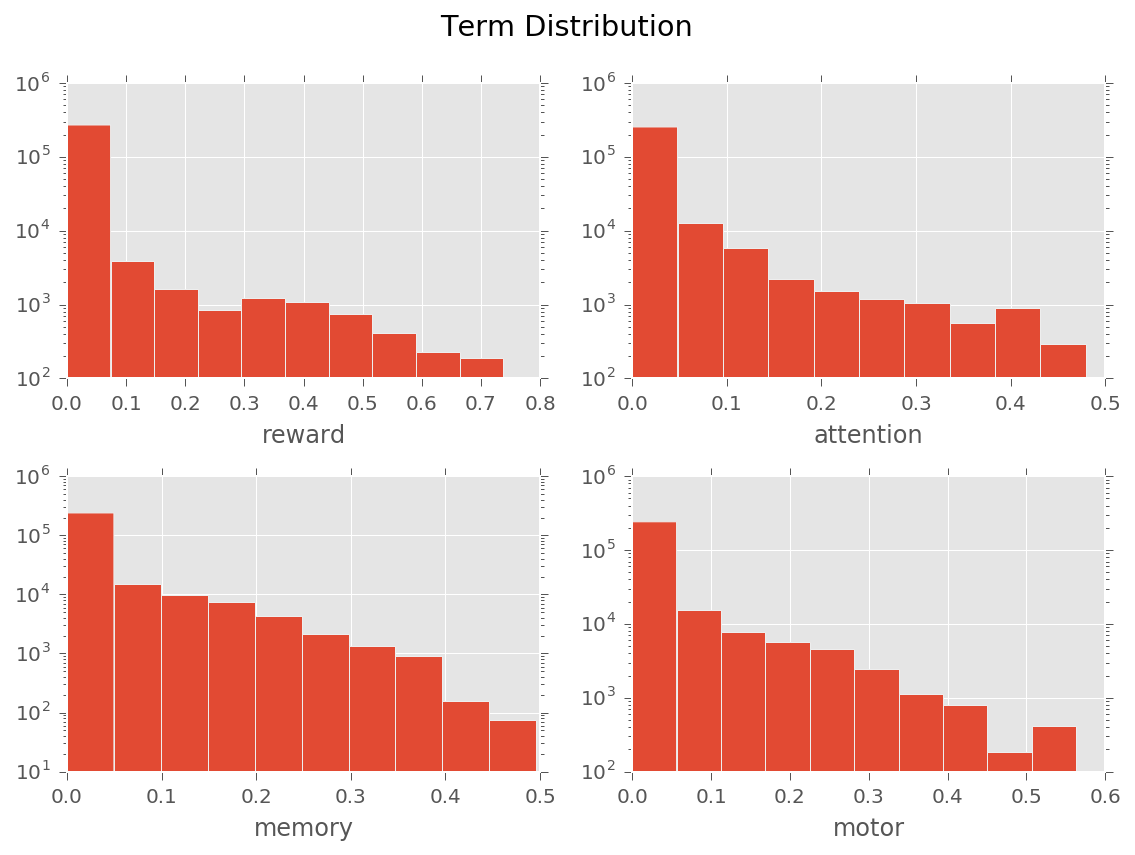

In [11]:
plt.suptitle("Term Distribution", fontsize='x-large');
for term, sb, df in zip(terms, range(221,225), dfs):
    plt.subplot(sb)
    df[term].hist(bins=10, figsize=(8,6));
    plt.yscale('log');
    plt.xlabel(term);

plt.tight_layout()
plt.subplots_adjust(top=.9)

In [48]:
A = df.loc[:, 'x':].as_matrix()
A.shape

(280228, 4)

In [64]:
%%time
# Average term activations at a given point

coord_counter = namedtuple("coord_counter", ["coordinate", "act", "count"])

D = {}
for term, df in zip(terms, dfs):
    td = {}
    A = df.loc[:, 'x':].as_matrix()
    for x in A:
        if str(x[:-1]) in td:
            # td [str(np.array(coord))] : (cumsum(NS activation), count)
            td[str(x[:-1])] = coord_counter(x[:-1], td[str(x[:-1])].act + x[-1], 
                               td[str(x[:-1])].count + 1) 
        else:
            td[str(x[:-1])] = coord_counter(x[:-1], x[-1], 1)
    D[term] = td
    

CPU times: user 10min 37s, sys: 5.39 s, total: 10min 42s
Wall time: 10min 54s


In [65]:
%%time
# Setting up principal data dictionary

for term in D.keys():
    X = []
    y = []
    for coord in D[term].keys():
        X.append(D[term][coord].coordinate)
        y.append(D[term][coord].act/float(D[term][coord].count))
    D[term] = (np.array(X), np.array(y))

CPU times: user 1.86 s, sys: 70 ms, total: 1.93 s
Wall time: 1.93 s


In [71]:
# Using namedtuple
CV_set = namedtuple("CV_set", ['X', 'y'])
for term in D.keys():
    D[term] = CV_set(D[term][0], D[term][1])

In [68]:
# Validation Helpers

def plot_vc(pars, train_scores, valid_scores, score, par_name, subplot, term):
    plt.subplot(subplot)
    plt.title(term)
    plt.plot(pars, np.mean(train_scores,1), label="Train")
    plt.plot(pars, np.mean(valid_scores,1), label="CV")
    plt.legend()
    plt.xlabel(par_name);
    plt.ylabel(score);
    
def print_scores(terms, pars, train_scores_, valid_scores_, par_name, error=True):
    entries = []
    if error:
        headers = ["Term", par_name, "Mean Training Error", "Mean CV Error"]
    else:
        headers = ["Term", par_name, "Mean Training Score", "Mean CV Score"]
    for tscores, vscores, term in zip(train_scores_, valid_scores_, terms):
        if error:
            t_means = -np.mean(train_scores,1)
            v_means = -np.mean(valid_scores,1)
            for par, t_err, v_err in zip(pars, t_means, v_means):
                entries.append([term, par, t_err, v_err]) 
        else:
            t_means = np.mean(train_scores,1)
            v_means = np.mean(valid_scores,1)
            for par, t_err, v_err in zip(pars, t_means, v_means):
                entries.append([term, par, t_err, v_err]) 
    print tabulate(entries, headers=headers)
    
def save_scores(path, terms, pars, train_scores_, 
                valid_scores_, par_name, score_fn, error=True):
    with open(path, 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        if error:
            headers = ["Term", par_name, "Mean Training Error", 
                       "Mean CV Error", "Error Function"]
        else:
            headers = ["Term", par_name, "Mean Training Score", 
                       "Mean CV Score", "Score Function"]
        writer.writerow(headers)
        for tscores, vscores, term in zip(train_scores_, valid_scores_, terms):
            if error:
                t_means = -np.mean(train_scores,1)
                v_means = -np.mean(valid_scores,1)
                for par, t_err, v_err in zip(pars, t_means, v_means):
                    writer.writerow([term, par, t_err, v_err, score_fn]) 
            else:
                t_means = np.mean(train_scores,1)
                v_means = np.mean(valid_scores,1)
                for par, t_err, v_err in zip(pars, t_means, v_means):
                     writer.writerow([term, par, t_err, v_err, score_fn]) 

In [69]:
# Checking estimation_csv exists
!ls
epath = "estimation_csv"

EI_Ratios.ipynb        neurosynth_dev         testing_nsaba.ipynb
Estimation.ipynb       nsaba_stats.ipynb
estimation_csv         testing_analysis.ipynb


# Decision Tree

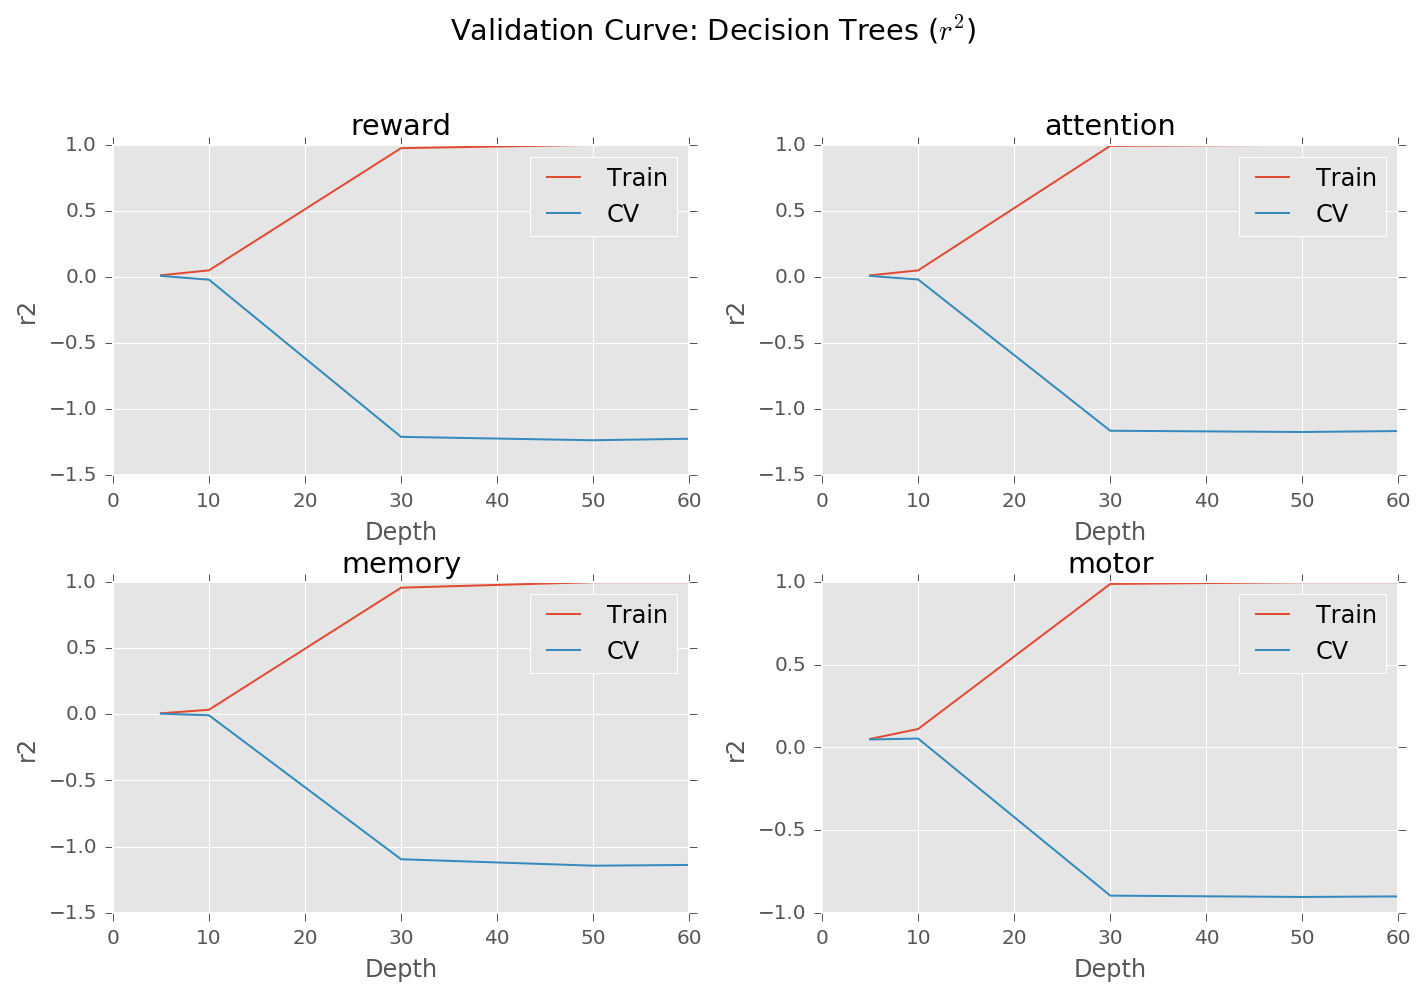

In [73]:
depth=[5,10,30,50,60]
score = 'r2'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Decision Trees ($r^{2}$)", fontsize='x-large')
for term, sb in zip(terms, range(221,225)):
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(),
                                                  D[term].X, D[term].y, "max_depth", depth, 
                                                  scoring=score, n_jobs=4, cv=5)
    plot_vc(depth, train_scores, valid_scores, 
            score, "Depth", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [74]:
# Printing and saving scores
print_scores(terms, depth, train_scores_, valid_scores_, "Max Depth", error=False)
save_scores(os.path.join(epath, "DT_r2.csv"), terms, depth, 
            train_scores_, valid_scores_, "Max Depth", score_fn=score, error=False)


Term         Max Depth    Mean Training Score    Mean CV Score
---------  -----------  ---------------------  ---------------
reward               5              0.0512101        0.0479671
reward              10              0.111255         0.0535539
reward              30              0.989237        -0.897334
reward              50              1               -0.90533
reward              60              1               -0.901996
attention            5              0.0512101        0.0479671
attention           10              0.111255         0.0535539
attention           30              0.989237        -0.897334
attention           50              1               -0.90533
attention           60              1               -0.901996
memory               5              0.0512101        0.0479671
memory              10              0.111255         0.0535539
memory              30              0.989237        -0.897334
memory              50              1               -0.90533
mem

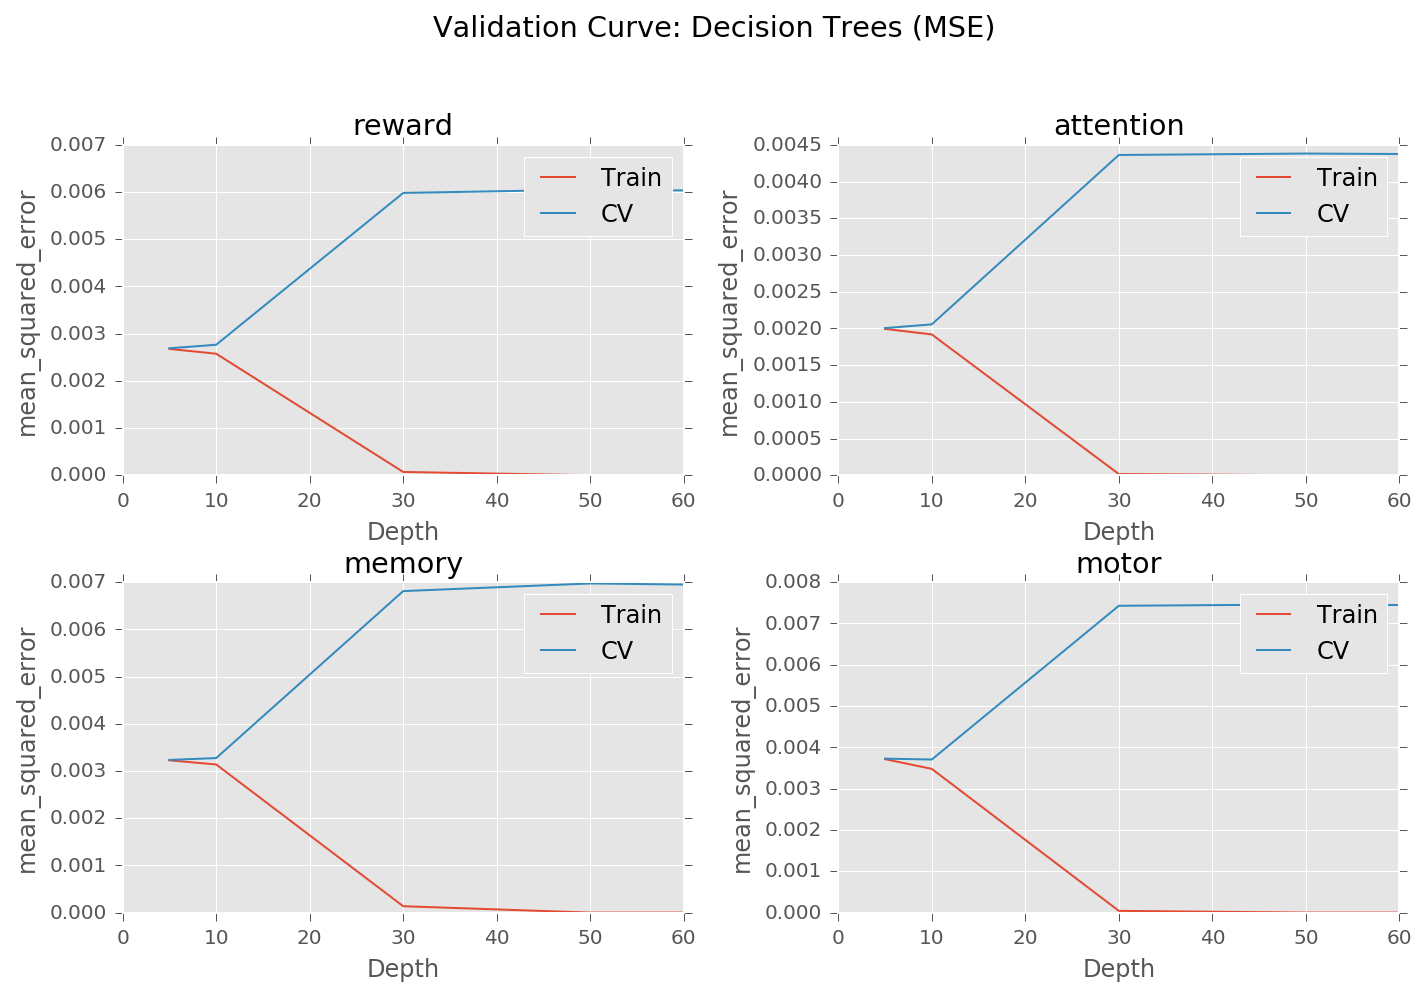

In [75]:
score = 'mean_squared_error'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Decision Trees (MSE)", fontsize='x-large')
for term, sb in zip(terms, range(221,225)):
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(),
                                                  D[term].X, D[term].y, "max_depth", depth, 
                                                  scoring=score, n_jobs=4, cv=5)
    plot_vc(depth, -train_scores, -valid_scores, 
            score, "Depth", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [76]:
# Printing and saving scores
print_scores(terms, depth, train_scores_, valid_scores_, "Max Depth", error=True)
save_scores(os.path.join(epath, "DT_mse.csv"), terms, depth, 
            train_scores_, valid_scores_, "Max Depth", score_fn=score, error=True)


Term         Max Depth    Mean Training Error    Mean CV Error
---------  -----------  ---------------------  ---------------
reward               5            0.00371511        0.00372773
reward              10            0.00348           0.00370579
reward              30            4.21344e-05       0.00742851
reward              50            6.04806e-11       0.0074598
reward              60            6.05207e-11       0.00744675
attention            5            0.00371511        0.00372773
attention           10            0.00348           0.00370579
attention           30            4.21344e-05       0.00742851
attention           50            6.04806e-11       0.0074598
attention           60            6.05207e-11       0.00744675
memory               5            0.00371511        0.00372773
memory              10            0.00348           0.00370579
memory              30            4.21344e-05       0.00742851
memory              50            6.04806e-11       0.007

# Random Forests

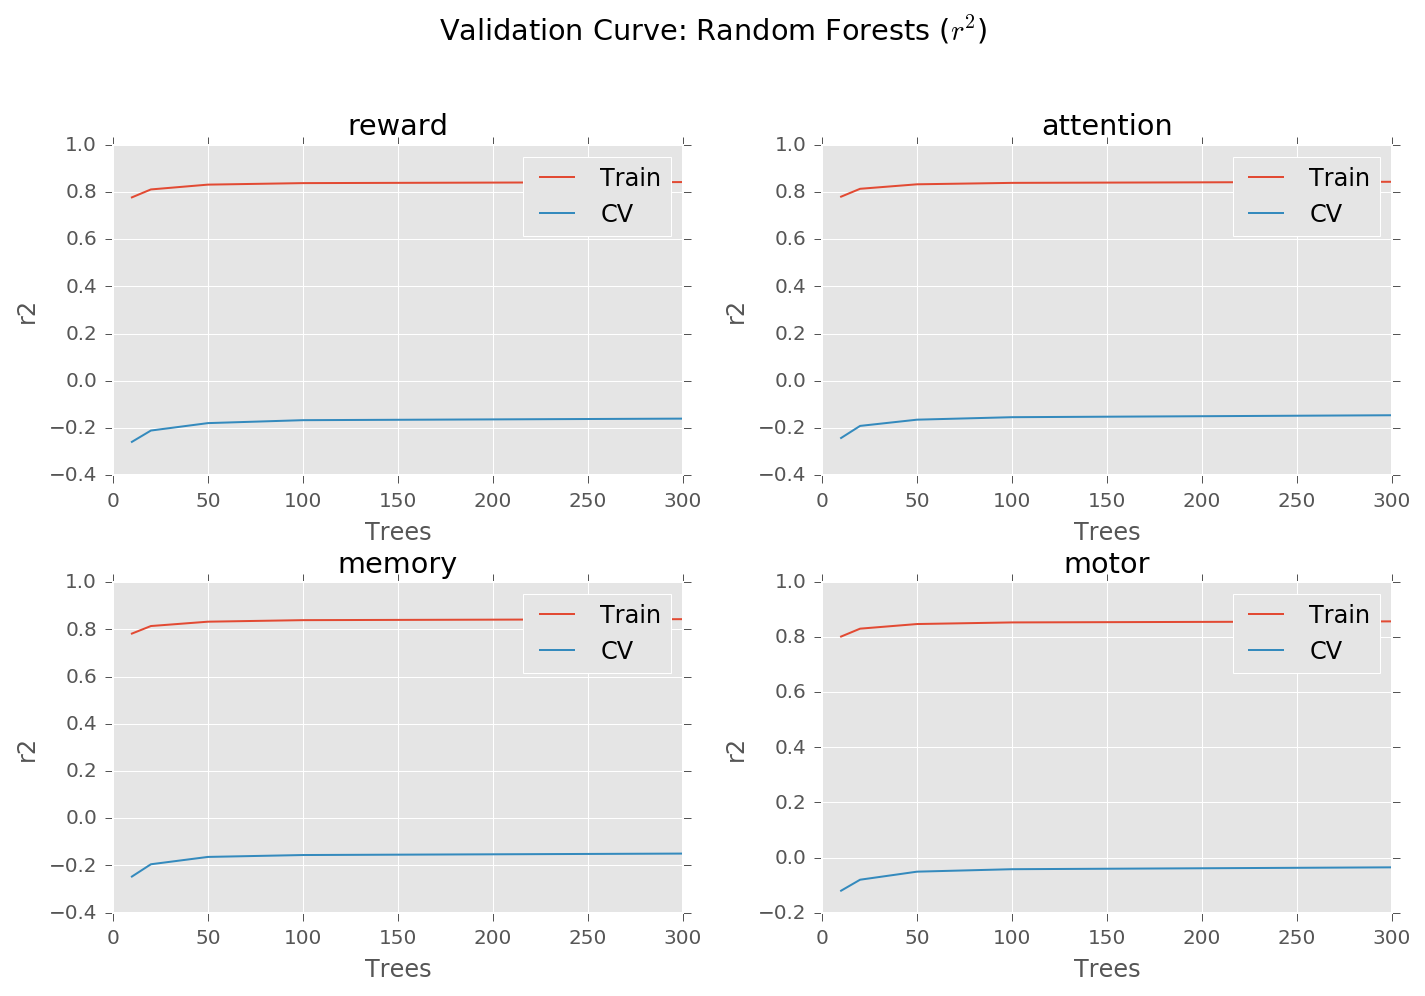

In [77]:
trees=[10,20,50,100,300]
score = 'r2'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Random Forests ($r^{2}$)", fontsize='x-large')
for term, sb in zip(terms, range(221,225)):
    train_scores, valid_scores = validation_curve(RandomForestRegressor(),
                                              D[term].X, D[term].y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(trees, train_scores, valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [78]:
# Printing and saving scores
print_scores(terms, trees, train_scores_, valid_scores_, "Trees", error=False)
save_scores(os.path.join(epath, "RF_r2.csv"), terms, trees, 
            train_scores_, valid_scores_, "Trees", score_fn=score, error=False)

Term         Trees    Mean Training Score    Mean CV Score
---------  -------  ---------------------  ---------------
reward          10               0.802514       -0.120423
reward          20               0.831172       -0.0805531
reward          50               0.847975       -0.0513138
reward         100               0.85385        -0.0423955
reward         300               0.857651       -0.0355973
attention       10               0.802514       -0.120423
attention       20               0.831172       -0.0805531
attention       50               0.847975       -0.0513138
attention      100               0.85385        -0.0423955
attention      300               0.857651       -0.0355973
memory          10               0.802514       -0.120423
memory          20               0.831172       -0.0805531
memory          50               0.847975       -0.0513138
memory         100               0.85385        -0.0423955
memory         300               0.857651       -0.0355973


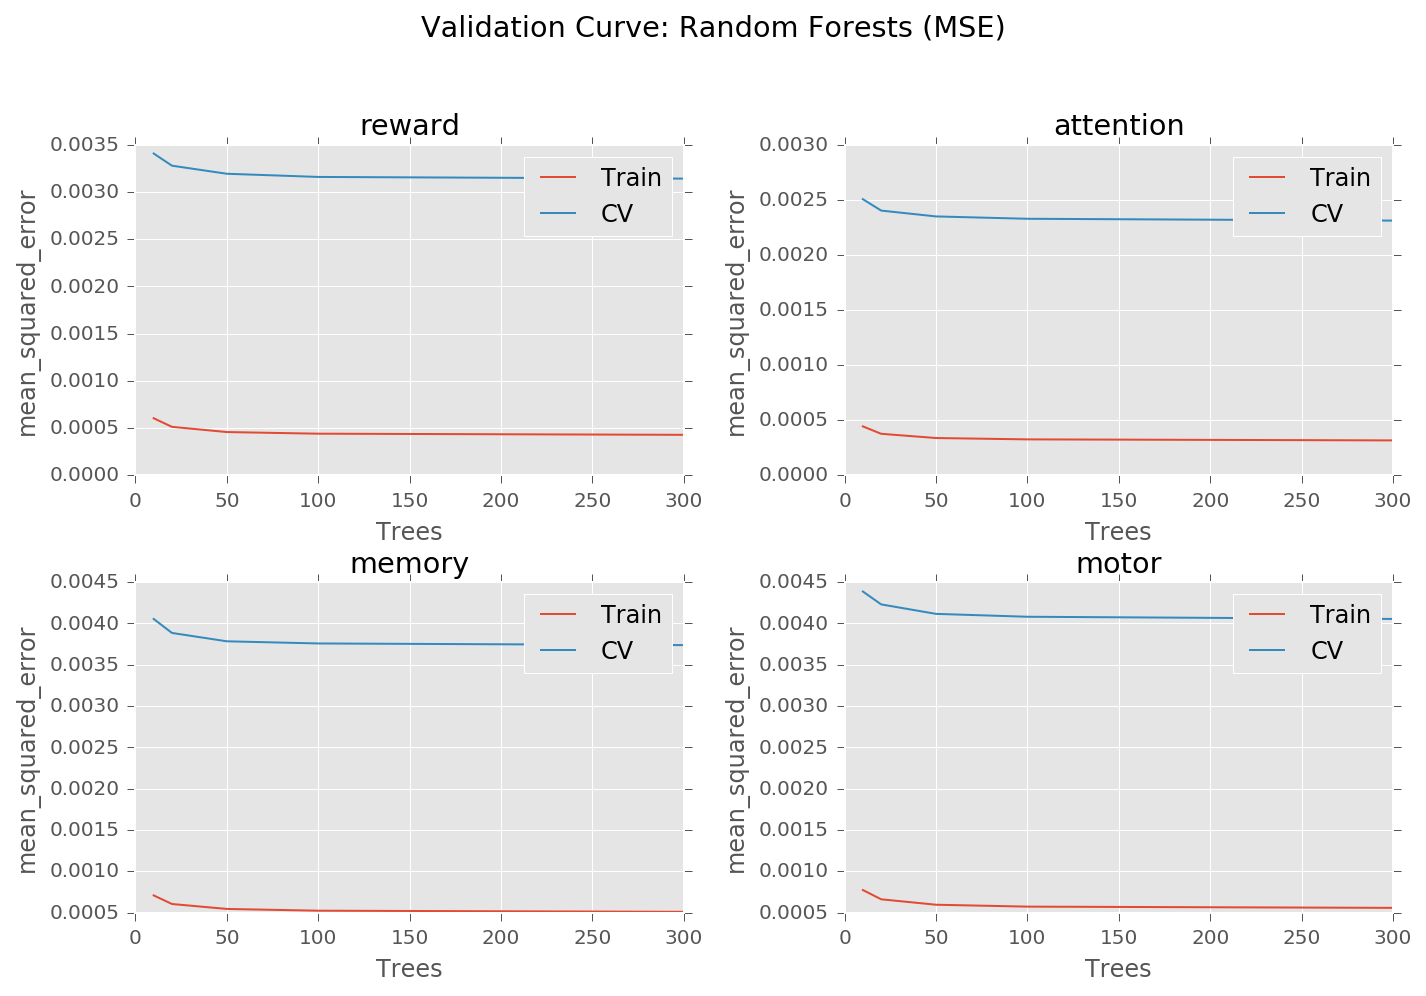

In [79]:
score='mean_squared_error'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Random Forests (MSE)", fontsize='x-large')
for term, sb in zip(terms, range(221,225)):
    train_scores, valid_scores = validation_curve(RandomForestRegressor(),
                                              D[term].X, D[term].y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(trees, -train_scores, -valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [80]:
# Printing and saving scores
print_scores(terms, trees, train_scores_, valid_scores_, "Trees")
save_scores(os.path.join(epath, "RF_mse.csv"), terms, trees, 
            train_scores_, valid_scores_, "Trees", score_fn=score)

Term         Trees    Mean Training Error    Mean CV Error
---------  -------  ---------------------  ---------------
reward          10            0.000773279       0.004387
reward          20            0.000661065       0.00423093
reward          50            0.000595272       0.00411636
reward         100            0.000572269       0.00408145
reward         300            0.000557386       0.00405486
attention       10            0.000773279       0.004387
attention       20            0.000661065       0.00423093
attention       50            0.000595272       0.00411636
attention      100            0.000572269       0.00408145
attention      300            0.000557386       0.00405486
memory          10            0.000773279       0.004387
memory          20            0.000661065       0.00423093
memory          50            0.000595272       0.00411636
memory         100            0.000572269       0.00408145
memory         300            0.000557386       0.00405486
mot

## KNN

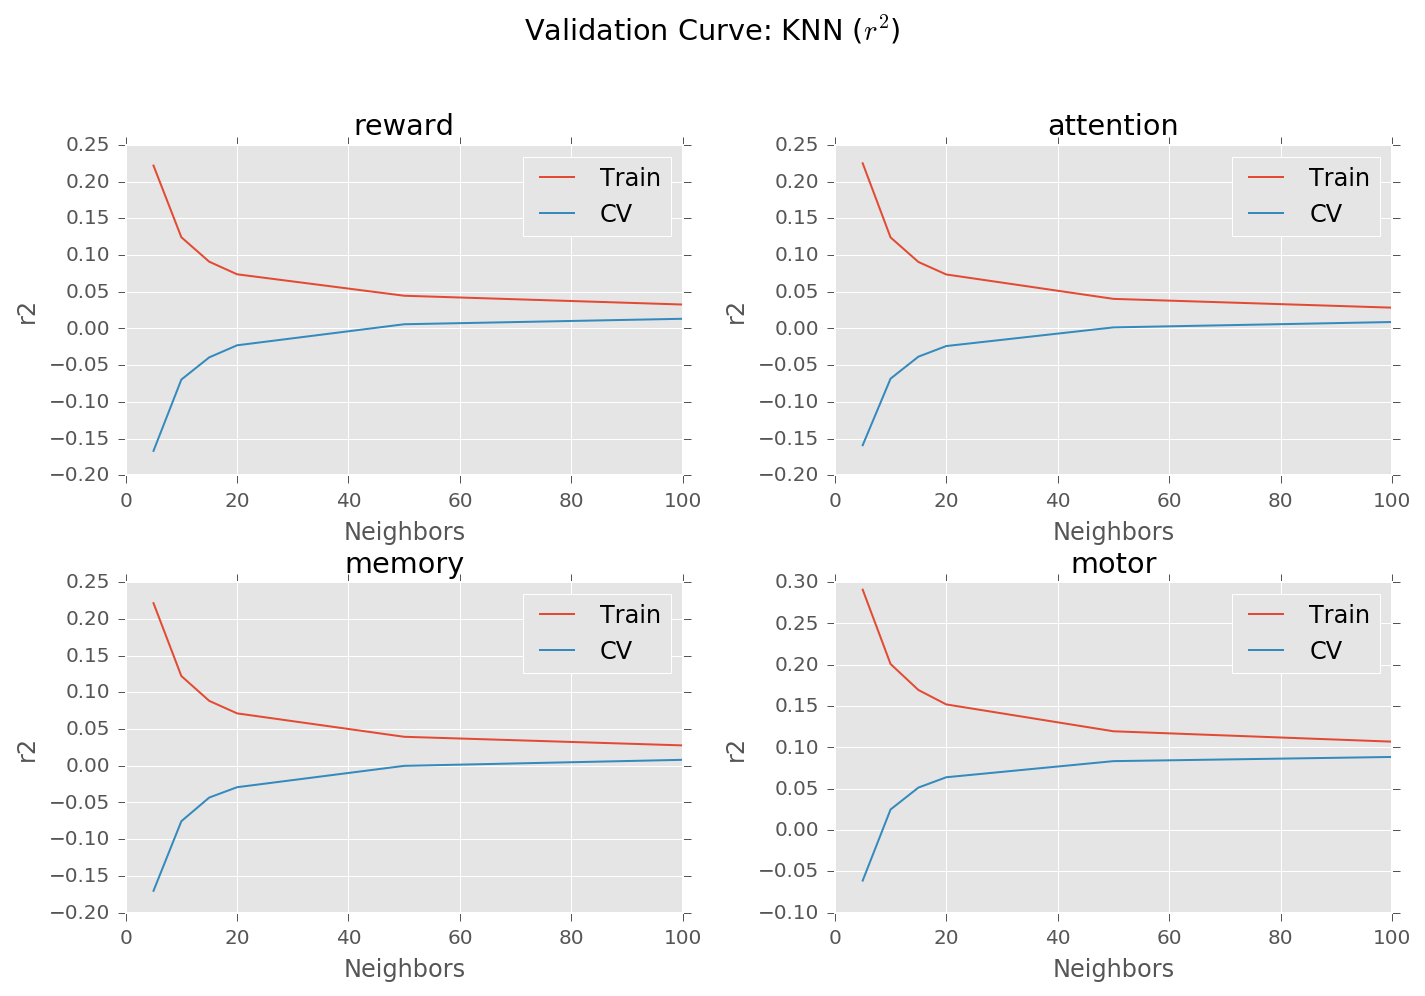

In [81]:
score = 'r2'
neighbors = [5,10,15,20,50,100]

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: KNN ($r^{2}$)", fontsize='x-large')
for term, sb in zip(terms, range(221,225)):
    train_scores, valid_scores = validation_curve(KNeighborsRegressor(),
                                              D[term].X, D[term].y, "n_neighbors", neighbors, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(neighbors, train_scores, valid_scores, 
            score, "Neighbors", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [82]:
# Printing and saving scores
print_scores(terms, neighbors, train_scores_, valid_scores_, "Neighbors", error=False)
save_scores(os.path.join(epath, "KNN_r2.csv"), terms, neighbors, 
            train_scores_, valid_scores_, "Neighbors", score_fn=score, error=False)

Term         Neighbors    Mean Training Score    Mean CV Score
---------  -----------  ---------------------  ---------------
reward               5               0.290891       -0.061232
reward              10               0.200943        0.024836
reward              15               0.169461        0.0513466
reward              20               0.152016        0.063848
reward              50               0.119508        0.0833531
reward             100               0.106948        0.0884211
attention            5               0.290891       -0.061232
attention           10               0.200943        0.024836
attention           15               0.169461        0.0513466
attention           20               0.152016        0.063848
attention           50               0.119508        0.0833531
attention          100               0.106948        0.0884211
memory               5               0.290891       -0.061232
memory              10               0.200943        0.024836


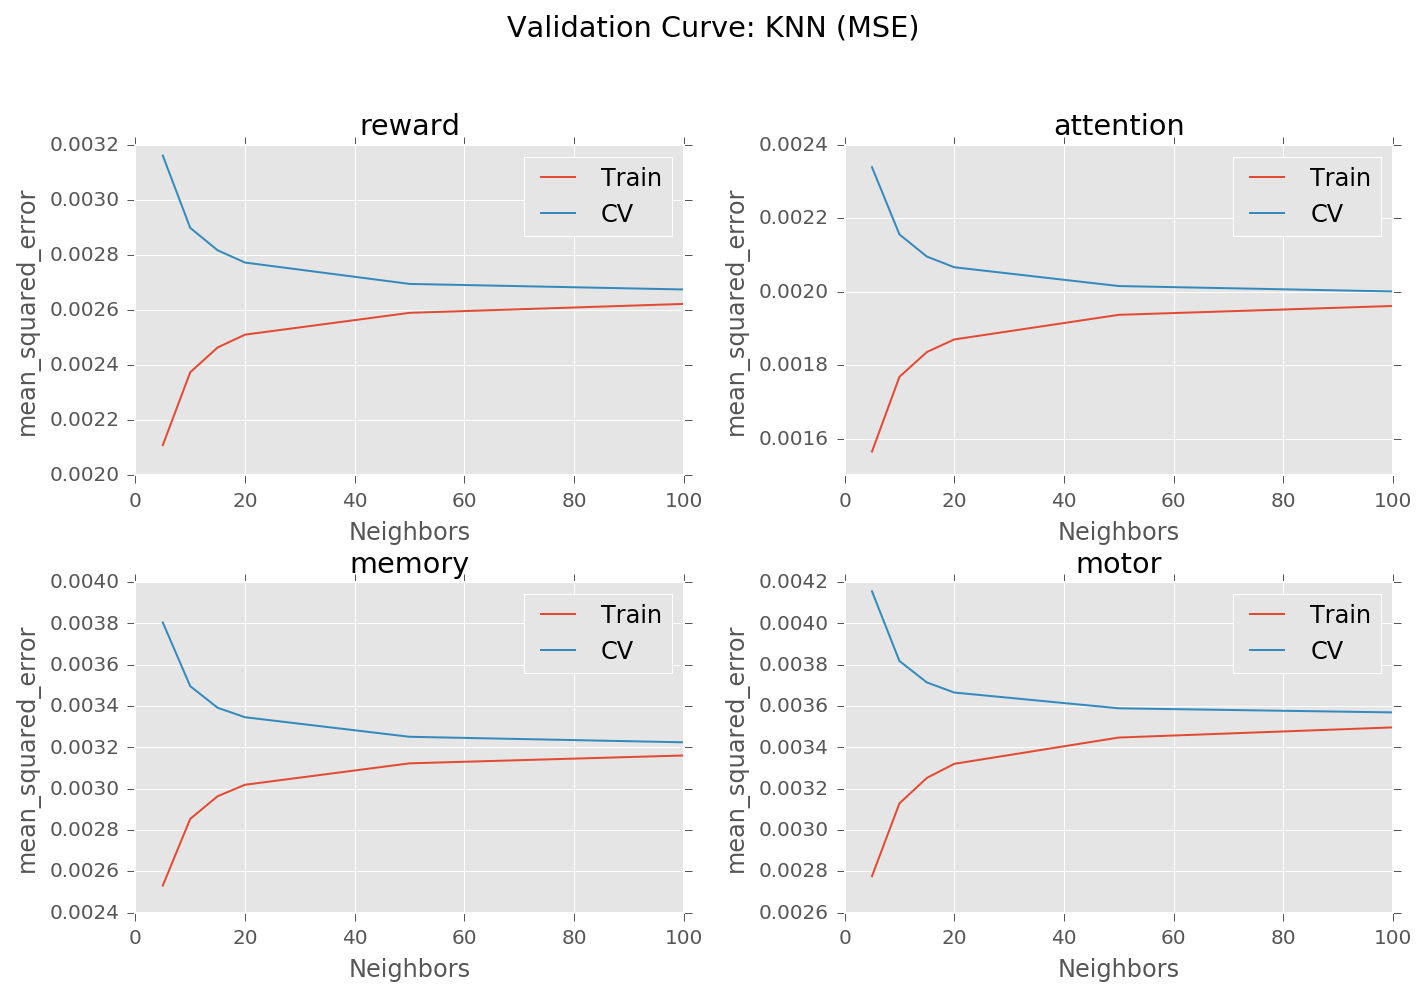

In [83]:
score='mean_squared_error'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: KNN (MSE)", fontsize='x-large')
for term, sb in zip(terms, range(221,225)):
    train_scores, valid_scores = validation_curve(KNeighborsRegressor(),
                                              D[term].X, D[term].y, "n_neighbors", neighbors, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(neighbors, -train_scores, -valid_scores, 
            score, "Neighbors", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [84]:
# Printing and saving scores
print_scores(terms, neighbors, train_scores_, valid_scores_, "Neighbors")
save_scores(os.path.join(epath, "KNN_mse.csv"), terms, neighbors, 
            train_scores_, valid_scores_, "Neighbors", score_fn=score)

Term         Neighbors    Mean Training Error    Mean CV Error
---------  -----------  ---------------------  ---------------
reward               5             0.0027766        0.00415527
reward              10             0.00312881       0.00381835
reward              15             0.00325208       0.00371457
reward              20             0.00332039       0.00366562
reward              50             0.00344768       0.00358923
reward             100             0.00349685       0.00356937
attention            5             0.0027766        0.00415527
attention           10             0.00312881       0.00381835
attention           15             0.00325208       0.00371457
attention           20             0.00332039       0.00366562
attention           50             0.00344768       0.00358923
attention          100             0.00349685       0.00356937
memory               5             0.0027766        0.00415527
memory              10             0.00312881       0.0

# Gradient Boosting

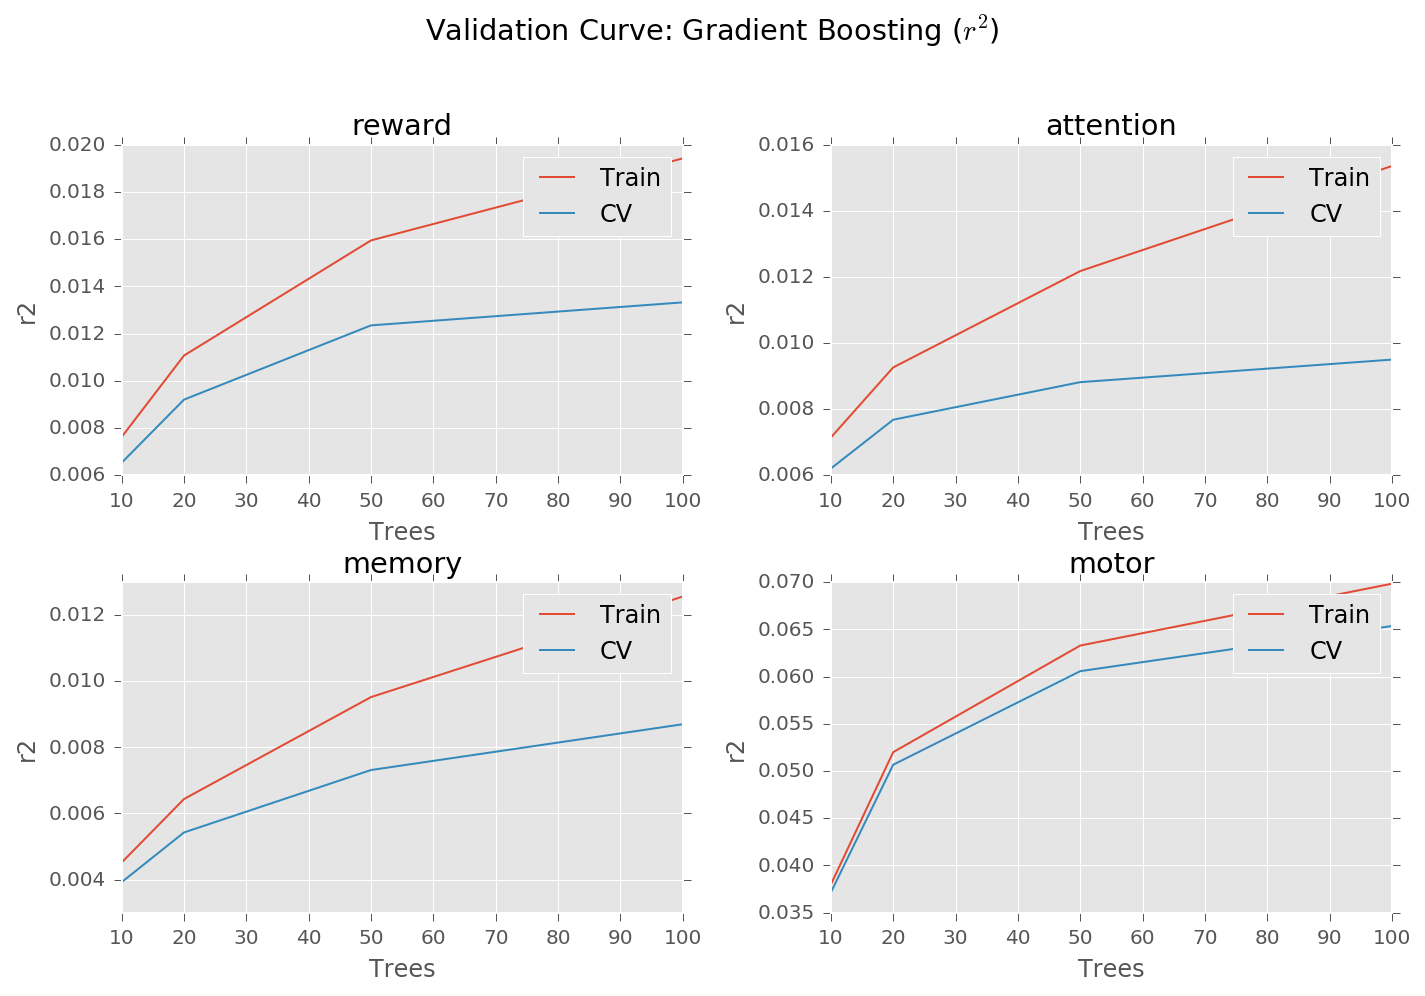

In [85]:
trees=[10,20,50,100]
score = 'r2'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Gradient Boosting ($r^{2}$)", fontsize='x-large')
for term, sb in zip(terms, range(221,225)):
    train_scores, valid_scores = validation_curve(GradientBoostingRegressor(),
                                              D[term].X, D[term].y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=4)
    plot_vc(trees, train_scores, valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [86]:
# Printing and saving scores
print_scores(terms, trees, train_scores_, valid_scores_, "Trees", error=False)
save_scores(os.path.join(epath, "GB_r2.csv"), terms, trees, 
            train_scores_, valid_scores_, "Trees", score_fn=score, error=False)

Term         Trees    Mean Training Score    Mean CV Score
---------  -------  ---------------------  ---------------
reward          10              0.0379709        0.0371323
reward          20              0.0519946        0.0506628
reward          50              0.0632869        0.060574
reward         100              0.0698389        0.0653601
attention       10              0.0379709        0.0371323
attention       20              0.0519946        0.0506628
attention       50              0.0632869        0.060574
attention      100              0.0698389        0.0653601
memory          10              0.0379709        0.0371323
memory          20              0.0519946        0.0506628
memory          50              0.0632869        0.060574
memory         100              0.0698389        0.0653601
motor           10              0.0379709        0.0371323
motor           20              0.0519946        0.0506628
motor           50              0.0632869        0.060574
m

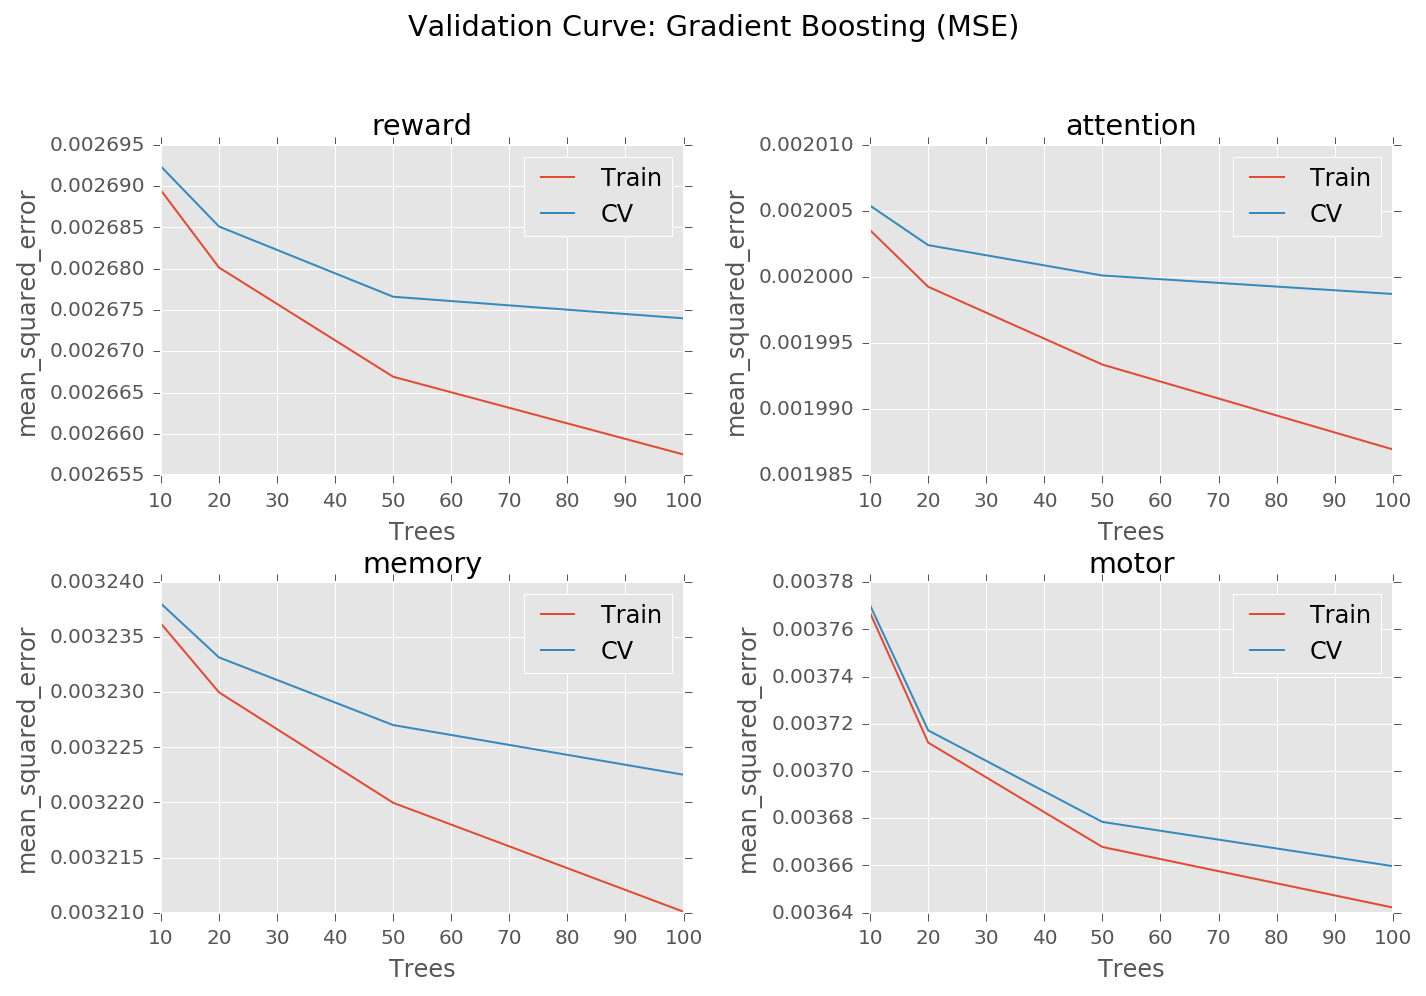

In [87]:
score='mean_squared_error'
train_scores_ = []
valid_scores_ = []
plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Gradient Boosting (MSE)", fontsize='x-large')
for term, sb in zip(terms, range(221,225)):
    train_scores, valid_scores = validation_curve(GradientBoostingRegressor(),
                                              D[term].X, D[term].y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=4)
    plot_vc(trees, -train_scores, -valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [88]:
# Printing and saving scores
print_scores(terms, trees, train_scores_, valid_scores_, "Trees", error=False)
save_scores(os.path.join(epath, "GB_mse.csv"), terms, trees, 
            train_scores_, valid_scores_, "Trees", score_fn=score, error=False)

Term         Trees    Mean Training Score    Mean CV Score
---------  -------  ---------------------  ---------------
reward          10            -0.00376695      -0.00377019
reward          20            -0.00371203      -0.00371722
reward          50            -0.00366781      -0.00367842
reward         100            -0.00364216      -0.00365968
attention       10            -0.00376695      -0.00377019
attention       20            -0.00371203      -0.00371722
attention       50            -0.00366781      -0.00367842
attention      100            -0.00364216      -0.00365968
memory          10            -0.00376695      -0.00377019
memory          20            -0.00371203      -0.00371722
memory          50            -0.00366781      -0.00367842
memory         100            -0.00364216      -0.00365968
motor           10            -0.00376695      -0.00377019
motor           20            -0.00371203      -0.00371722
motor           50            -0.00366781      -0.003678